In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

(a) Plot the graph with given code, the result should be same as this.
![](originalData.png)
`x_train` and `y_train` are the datas you need to create, `sample_size` is 10 and `std` is 0.25. 

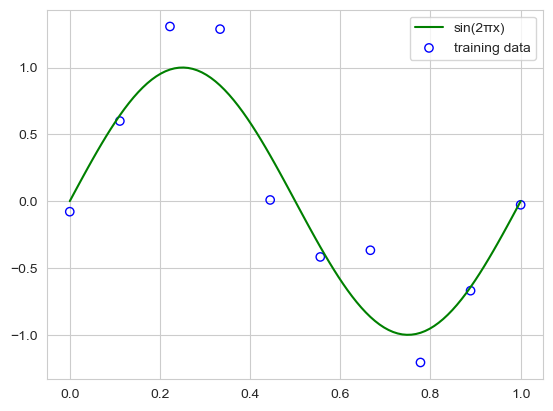

In [16]:
# Write you codes here.
plt.plot(x_test, y_test, label='sin(2πx)', color='g')
plt.scatter(x_train, y_train, c='none',marker='o',edgecolors='b', label='training data')
plt.legend()

(b) On the basis of the results, you should try $0^{th}$ order polynomial, $1^{st}$ order polynomial, $3^{rd}$ order polynomial and some other order polynomial, show the results include fitting and over-fitting.
![](fitting.png)

In [4]:
class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=2):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()
    
class Regression(object):
    """
    Base class for regressors
    """
    pass
    
class LinearRegression(Regression):
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each predition if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each predition
        """
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

In [5]:
# Write your codes here.


(c) Plot the graph of the root-mean-square error.
![](rmse.png)

In [6]:
def rmse(a, b):
    # Complete this function

SyntaxError: incomplete input (4077701825.py, line 2)

In [ ]:
# Write your codes here.
training_erroes = []
test_errors = []

(d) Plot the graph of the predictive distribution resulting from a Bayesian treatment of polynomial curve fitting using an M=9 polynomial, with the fixed parameters $\alpha=5\times 10^{-3}$ and $\beta=11.1$(corresponding to the known noise variance).
![](bayesianRegression.png)

In [ ]:
class BayesianRegression(Regression):
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

In [ ]:
# Write your codes here.


(e) Change the $sample\_size$ to 2, 3 or 10 times than before, explain the change of $M$.

In [ ]:
# Write your codes here.
